In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Loading the data
prices=pd.read_csv('/content/drive/MyDrive/sell_prices.csv')
sales=pd.read_csv('/content/drive/MyDrive/sales_train_validation.csv')
calendar=pd.read_csv('/content/drive/MyDrive/calendar.csv')

In [5]:
# Dimension/shape of the files
print('Prices:',prices.shape)
print('Sales:',sales.shape)
print('Calendar:',calendar.shape)

Prices: (6841121, 4)
Sales: (30490, 1919)
Calendar: (1969, 14)


In [6]:
print(prices.head())

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26


In [7]:
print(sales.head())


                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  


In [8]:
print(calendar.head())

         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  


<Axes: title={'center': 'Daily Sales Trend'}, xlabel='date'>

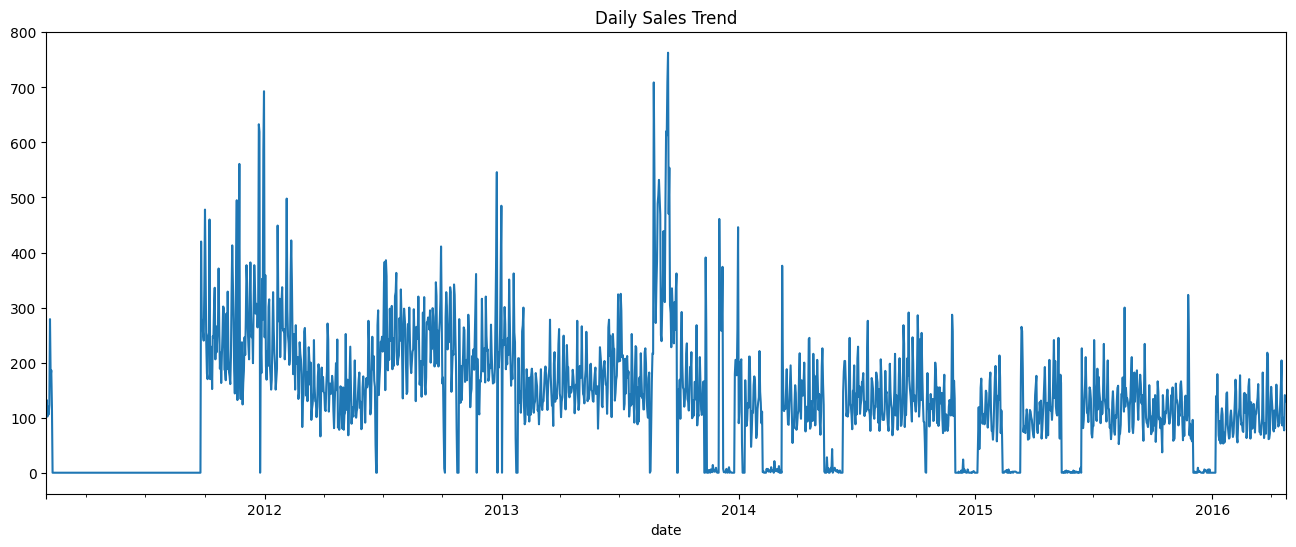

In [9]:
sample_series = sales[(sales['item_id'] == 'FOODS_3_090') & (sales['store_id'] == 'CA_3')].iloc[:, 6:]
sample_series = sample_series.T  # Transpose
sample_series.columns = ['sales']
sample_series['date'] = pd.date_range(start='2011-01-29', periods=sample_series.shape[0])

# Plot
sample_series.set_index('date')['sales'].plot(figsize=(16,6), title="Daily Sales Trend")

In [10]:
# Filter before melt (Reshaping)
sales_small = sales[sales['store_id'] == 'CA_1']

# Melt sales data to long format
sales_long = sales_small.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],   # Keep these columns fixed
    var_name='d',                                                             # New column name for old column headers
    value_name='sales'                                                        # New column name for values
)

In [11]:
import duckdb

# Register tables in DuckDB
duckdb.register("sales_long", sales_long)
duckdb.register("calendar", calendar)
duckdb.register("prices", prices)

In [12]:
duckdb.query("SELECT * FROM sales_long LIMIT 5").df()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [13]:
duckdb.query("""
    SELECT
        s.id, s.item_id, s.store_id, c.date, s.sales
    FROM sales_long s
    JOIN calendar c
    ON s.d = c.d
    LIMIT 10
""").df()


,id,item_id,store_id,date,sales
0,FOODS_1_175_CA_1_validation,FOODS_1_175,CA_1,2011-03-03,0
1,FOODS_1_176_CA_1_validation,FOODS_1_176,CA_1,2011-03-03,0
2,FOODS_1_177_CA_1_validation,FOODS_1_177,CA_1,2011-03-03,1
3,FOODS_1_178_CA_1_validation,FOODS_1_178,CA_1,2011-03-03,0
4,FOODS_1_179_CA_1_validation,FOODS_1_179,CA_1,2011-03-03,0
5,FOODS_1_180_CA_1_validation,FOODS_1_180,CA_1,2011-03-03,0
6,FOODS_1_181_CA_1_validation,FOODS_1_181,CA_1,2011-03-03,0
7,FOODS_1_182_CA_1_validation,FOODS_1_182,CA_1,2011-03-03,0
8,FOODS_1_183_CA_1_validation,FOODS_1_183,CA_1,2011-03-03,0
9,FOODS_1_184_CA_1_validation,FOODS_1_184,CA_1,2011-03-03,0


In [14]:
duckdb.query("""
    SELECT
        s.id, s.item_id, s.store_id, c.date, s.sales, p.sell_price
    FROM sales_long s
    JOIN calendar c ON s.d = c.d
    LEFT JOIN prices p
        ON p.item_id = s.item_id
        AND p.store_id = s.store_id
        AND p.wm_yr_wk = c.wm_yr_wk
    LIMIT 10
""").df()

,id,item_id,store_id,date,sales,sell_price
0,FOODS_1_176_CA_1_validation,FOODS_1_176,CA_1,2011-03-03,0,2.97
1,FOODS_1_177_CA_1_validation,FOODS_1_177,CA_1,2011-03-03,1,7.97
2,FOODS_1_178_CA_1_validation,FOODS_1_178,CA_1,2011-03-03,0,8.97
3,FOODS_1_180_CA_1_validation,FOODS_1_180,CA_1,2011-03-03,0,8.88
4,FOODS_1_183_CA_1_validation,FOODS_1_183,CA_1,2011-03-03,0,2.88
5,FOODS_1_185_CA_1_validation,FOODS_1_185,CA_1,2011-03-03,0,2.00
6,FOODS_1_187_CA_1_validation,FOODS_1_187,CA_1,2011-03-03,1,7.97
7,FOODS_1_192_CA_1_validation,FOODS_1_192,CA_1,2011-03-03,1,2.38
8,FOODS_1_194_CA_1_validation,FOODS_1_194,CA_1,2011-03-03,8,3.97
9,FOODS_1_195_CA_1_validation,FOODS_1_195,CA_1,2011-03-03,0,2.18


In [15]:
df = duckdb.query("""
    SELECT
        s.id, s.item_id, s.store_id, c.date, s.sales,
        p.sell_price, c.event_name_1, c.event_type_1
    FROM sales_long s
    JOIN calendar c ON s.d = c.d
    LEFT JOIN prices p
        ON p.item_id = s.item_id
        AND p.store_id = s.store_id
        AND p.wm_yr_wk = c.wm_yr_wk
    WHERE s.store_id = 'CA_1'

""").df()


In [16]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [17]:
# Step 1: Drop invalid date rows (if any)
df = df[df['date'].notna()]   # Keep the rows where value is True (Not NaT)

In [18]:
# Step 2: Feature engineering
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['is_event'] = df['event_name_1'].notnull().astype(int)

In [19]:
# Step 3: Lag features
df['lag_7'] = df.groupby('id')['sales'].shift(7)
df['lag_28'] = df.groupby('id')['sales'].shift(28)

In [20]:
# Step 4: Rolling features (mean and std over past 7 days)
df['rolling_mean_7'] = df.groupby('id')['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
df['rolling_std_7'] = df.groupby('id')['sales'].transform(lambda x: x.shift(1).rolling(7).std())

# Price-based features
df['price_norm'] = df['sell_price'] / df.groupby('id')['sell_price'].transform('max')
df['price_change'] = df.groupby('id')['sell_price'].transform(lambda x: x.pct_change(fill_method=None))

In [21]:
# Step 5: Drop rows with NaNs (from lag features)
df.dropna(subset=['lag_7', 'lag_28'], inplace=True)

In [22]:
print(df.columns.tolist())

['id', 'item_id', 'store_id', 'date', 'sales', 'sell_price', 'event_name_1', 'event_type_1', 'dayofweek', 'month', 'is_event', 'lag_7', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'price_norm', 'price_change']


In [23]:
print(df['date'].min(), df['date'].max())

2011-01-29 00:00:00 2016-04-24 00:00:00


In [24]:
# Define features and target
features = ['lag_7', 'lag_28', 'dayofweek', 'month', 'is_event',
            'rolling_mean_7', 'rolling_std_7', 'price_norm', 'price_change']

# Train/Validation split by date
train_df = df[df['date'] < "2016-04-01"]
valid_df = df[df['date'] >= "2016-04-01"]

X_train = train_df[features]
y_train = train_df['sales']

X_valid = valid_df[features]
y_valid = valid_df['sales']

In [25]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_valid:", X_valid.shape)
print("y_valid:", y_valid.shape)

X_train: (5674189, 9)
y_train: (5674189,)
X_valid: (73176, 9)
y_valid: (73176,)


In [26]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    objective='regression',
    random_state=42
)

# Use callbacks instead of early_stopping_rounds directly
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.702589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 5674189, number of used features: 9
[LightGBM] [Info] Start training from score 1.321685
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 4.33406
[200]	valid_0's l2: 4.31967
[300]	valid_0's l2: 4.30861
[400]	valid_0's l2: 4.29862
Early stopping, best iteration is:
[400]	valid_0's l2: 4.29862


LGBMRegressor(learning_rate=0.05, n_estimators=1000, objective='regression',
              random_state=42)

In [27]:
y_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 2.0733


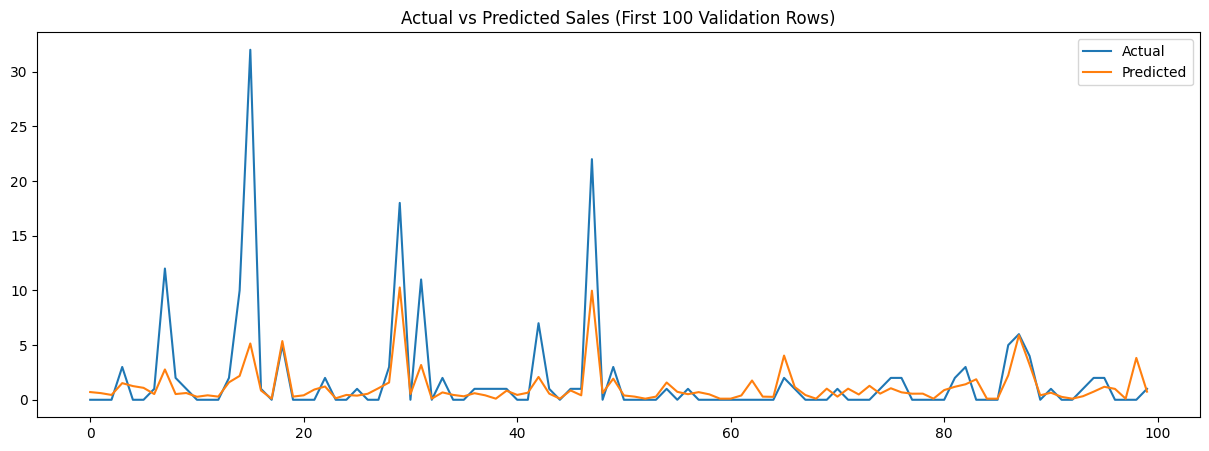

In [28]:
plt.figure(figsize=(15,5))
plt.plot(y_valid.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Sales (First 100 Validation Rows)")
plt.show()

In [29]:
import joblib
joblib.dump(model, 'lgbm_model.pkl')

['lgbm_model.pkl']

In [33]:
from google.colab import files
files.download("lgbm_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>